In [1]:
import numpy as np

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torchvision import datasets

import matplotlib.pyplot as plt

In [2]:
def func(x):
    return (np.sin(x)/x)-x/10

In [177]:
def data_generator(num_samples, lower, upper):
    
    x = np.linspace(lower, upper, num_samples)
    y = np.array([func(x) for x in x])
    
    data = np.stack((x, y))
    return data

In [126]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [178]:
data = data_generator(int(1e6), int(-0.5e3), int(0.5e3))

In [190]:
data = data.reshape(2, -1, 1, 100)

In [191]:
data.shape

(2, 10000, 1, 100)

In [206]:
data = data.transpose((1, 0, 2, 3))

In [207]:
data.shape

(10000, 2, 1, 100)

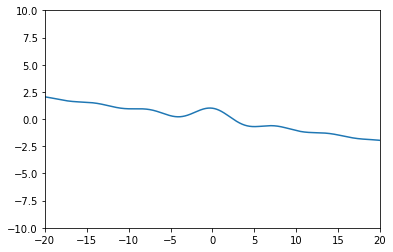

In [208]:
plt.plot(data[:, 0, :, :].reshape(-1, 1), data[:, 1, :, :].reshape(-1, 1))
plt.xlim((-20, 20))
plt.ylim((-10, 10))
plt.show()

In [168]:
data[:, :, 0].reshape(-1, 1).std(), data[:, :, 1].reshape(-1, 1).std()

(288.6754232700917, 28.86759653482953)

In [209]:
norm = transforms.Normalize([0, 0], [data[:, 0, :, :].reshape(-1, 1).std(), data[:, 1, :, :].reshape(-1, 1).std()])

In [212]:
data = torch.FloatTensor(data)

In [213]:
norm_data = norm(data)

ValueError: Expected tensor to be a tensor image of size (C, H, W). Got tensor.size() = torch.Size([10000, 2, 1, 100]).

In [143]:
n_epochs = 1000
batch_size = 64
lr = 0.0001

b1 = 0.5
b2 = 0.999
num_dots = 100
sample_interval = 25

In [155]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers=[nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, num_dots*2))
        
    def forward(self, x):
        dots = self.model(x)
        dots = dots.view(dots.size(0), num_dots, 2)
        return dots

In [46]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Linear(num_dots*2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid())
        
    def forward(self, x):
        dots_flat = x.view(x.size(0), -1)
        val = self.model(dots_flat)
        return val

In [125]:
train_data = DataLoader(data, batch_size=batch_size, shuffle=True)

In [144]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr, betas = (b1, b2))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

loss = torch.nn.BCELoss()

In [145]:
d_loss_history = []
g_loss_history = []
dots_history = []

In [87]:
def sample_dots(dots):
    idx = np.random.choice(len(dots))
    res = dots[idx].to('cpu').detach().numpy()
    return res

In [146]:
for epoch in range(n_epochs):
    
    for i, dots in enumerate(train_data):
        batch_size = dots.size(0)
        #Labels for real and fake data
        valid = torch.ones([batch_size, 1], requires_grad=False, dtype=torch.float32, device=device)
        fake = torch.zeros([batch_size, 1], requires_grad=False, dtype=torch.float32, device=device)
        
        real_dots = dots.type(torch.FloatTensor).to(device)
        
        #Train generator
        
        optimizer_g.zero_grad()
        
        z = torch.randn([batch_size, 100], device=device)
        
        gen_dots = generator(z)
        
        validity = discriminator(gen_dots)
        g_loss = loss(validity, valid)
        g_loss.backward()
        optimizer_g.step()
        
        #Train discriminator
        
        optimizer_d.zero_grad()
        
        real_pred = discriminator(real_dots)
        d_real_loss = loss(real_pred, valid)
        
        fake_pred = discriminator(gen_dots.detach())
        d_fake_loss = loss(fake_pred, fake)
        
        d_loss = (d_real_loss + d_fake_loss)/2
        d_loss.backward()
        optimizer_d.step()
        
        batches_done = epoch*len(train_data) + i
        if batches_done % sample_interval == 0:
            d_loss_history.append(d_loss)
            g_loss_history.append(g_loss)
        if batches_done % len(train_data) == 0:
            dots_history.append(sample_dots(gen_dots))
            print(f'Epoch {epoch}: g_loss={g_loss}, d_loss={d_loss}')

Epoch 0: g_loss=0.7004857063293457, d_loss=0.41343367099761963
Epoch 1: g_loss=0.8254818320274353, d_loss=0.29889941215515137
Epoch 2: g_loss=1.1036725044250488, d_loss=0.21916897594928741
Epoch 3: g_loss=0.5764952898025513, d_loss=26.55071258544922
Epoch 4: g_loss=0.883109450340271, d_loss=0.29798972606658936
Epoch 5: g_loss=1.5894558429718018, d_loss=0.12362969666719437
Epoch 6: g_loss=1.8513869047164917, d_loss=0.12169335782527924
Epoch 7: g_loss=2.1342673301696777, d_loss=0.08270793408155441
Epoch 8: g_loss=2.387071132659912, d_loss=0.04833066463470459
Epoch 9: g_loss=2.6602060794830322, d_loss=0.041747353971004486
Epoch 10: g_loss=2.9875636100769043, d_loss=0.057106465101242065
Epoch 11: g_loss=3.1930880546569824, d_loss=0.02095930092036724
Epoch 12: g_loss=3.4273219108581543, d_loss=0.019942961633205414
Epoch 13: g_loss=3.3337509632110596, d_loss=0.05911191925406456
Epoch 14: g_loss=3.6885435581207275, d_loss=0.014611477963626385
Epoch 15: g_loss=3.9052023887634277, d_loss=0.0102

Epoch 128: g_loss=5.361392974853516, d_loss=0.0027742076199501753
Epoch 129: g_loss=6.4839630126953125, d_loss=0.11038844287395477
Epoch 130: g_loss=6.999306678771973, d_loss=0.0004915106110274792
Epoch 131: g_loss=6.4793195724487305, d_loss=0.0007786104688420892
Epoch 132: g_loss=6.252050399780273, d_loss=0.000989684835076332
Epoch 133: g_loss=6.2834014892578125, d_loss=0.04951474070549011
Epoch 134: g_loss=5.552902698516846, d_loss=0.04703262448310852
Epoch 135: g_loss=7.067375183105469, d_loss=0.0004267313051968813
Epoch 136: g_loss=6.644967079162598, d_loss=0.0006549936369992793
Epoch 137: g_loss=6.616491317749023, d_loss=0.0007229988696053624
Epoch 138: g_loss=5.528233528137207, d_loss=0.005360236391425133
Epoch 139: g_loss=6.579320907592773, d_loss=0.0009197983890771866
Epoch 140: g_loss=5.668591499328613, d_loss=0.0018810390029102564
Epoch 141: g_loss=6.711671829223633, d_loss=0.06128412485122681
Epoch 142: g_loss=6.744900226593018, d_loss=0.0007990931044332683
Epoch 143: g_loss

Epoch 253: g_loss=5.875288486480713, d_loss=0.05078279227018356
Epoch 254: g_loss=6.193124771118164, d_loss=0.05010274425148964
Epoch 255: g_loss=5.572445869445801, d_loss=0.0026049287989735603
Epoch 256: g_loss=6.136999607086182, d_loss=0.0010878692846745253
Epoch 257: g_loss=6.4074201583862305, d_loss=0.0008397180354222655
Epoch 258: g_loss=5.842855453491211, d_loss=0.0014744687359780073
Epoch 259: g_loss=6.155241966247559, d_loss=0.001077048247680068
Epoch 260: g_loss=6.3882036209106445, d_loss=0.0008515235385857522
Epoch 261: g_loss=6.193765640258789, d_loss=0.001041898038238287
Epoch 262: g_loss=6.049769401550293, d_loss=0.0011815668549388647
Epoch 263: g_loss=6.572084426879883, d_loss=0.0007117670029401779
Epoch 264: g_loss=6.197419166564941, d_loss=0.0010223116260021925
Epoch 265: g_loss=5.802975654602051, d_loss=0.001684049959294498
Epoch 266: g_loss=6.100351333618164, d_loss=0.0012481966987252235
Epoch 267: g_loss=6.680746555328369, d_loss=0.000629509158898145
Epoch 268: g_los

Epoch 378: g_loss=5.709427833557129, d_loss=0.0016695839585736394
Epoch 379: g_loss=6.48126220703125, d_loss=0.0007708286866545677
Epoch 380: g_loss=5.769747734069824, d_loss=0.0016087123658508062
Epoch 381: g_loss=6.934726715087891, d_loss=0.0004978536162525415
Epoch 382: g_loss=6.2680745124816895, d_loss=0.0010082372464239597
Epoch 383: g_loss=6.338787078857422, d_loss=0.0008908766903914511
Epoch 384: g_loss=6.236867904663086, d_loss=0.03219977393746376
Epoch 385: g_loss=5.661938667297363, d_loss=0.0017728901002556086
Epoch 386: g_loss=5.654628276824951, d_loss=0.047193605452775955
Epoch 387: g_loss=5.972446441650391, d_loss=0.046844732016325
Epoch 388: g_loss=5.756988048553467, d_loss=0.0016946732066571712
Epoch 389: g_loss=6.590030193328857, d_loss=0.05446603521704674
Epoch 390: g_loss=5.826390743255615, d_loss=0.0014815188478678465
Epoch 391: g_loss=6.505458354949951, d_loss=0.0009674270986579359
Epoch 392: g_loss=6.4282612800598145, d_loss=0.0008174703689292073
Epoch 393: g_loss=

Epoch 504: g_loss=6.017043113708496, d_loss=0.04713309556245804
Epoch 505: g_loss=6.530148506164551, d_loss=0.0007612832123413682
Epoch 506: g_loss=6.3115949630737305, d_loss=0.0009493519319221377
Epoch 507: g_loss=6.650433540344238, d_loss=0.0006478777504526079
Epoch 508: g_loss=6.2067341804504395, d_loss=0.04958784580230713
Epoch 509: g_loss=6.087123870849609, d_loss=0.00114220823161304
Epoch 510: g_loss=6.787353515625, d_loss=0.0005652975523844361
Epoch 511: g_loss=6.286495208740234, d_loss=0.0009337329538539052
Epoch 512: g_loss=6.910628318786621, d_loss=0.05157638341188431
Epoch 513: g_loss=5.495771884918213, d_loss=0.00419562729075551
Epoch 514: g_loss=5.589641571044922, d_loss=0.0021972774993628263
Epoch 515: g_loss=6.5802435874938965, d_loss=0.051343828439712524
Epoch 516: g_loss=5.726065158843994, d_loss=0.001648806850425899
Epoch 517: g_loss=6.586732864379883, d_loss=0.0006917824503034353
Epoch 518: g_loss=6.148989200592041, d_loss=0.047429218888282776
Epoch 519: g_loss=6.509

Epoch 629: g_loss=5.950815200805664, d_loss=0.0014358432963490486
Epoch 630: g_loss=5.490687847137451, d_loss=0.048376552760601044
Epoch 631: g_loss=6.180394172668457, d_loss=0.0010468983091413975
Epoch 632: g_loss=5.920297622680664, d_loss=0.04892546683549881
Epoch 633: g_loss=5.94373893737793, d_loss=0.0013230763142928481
Epoch 634: g_loss=6.001105308532715, d_loss=0.0012952473480254412
Epoch 635: g_loss=5.999983787536621, d_loss=0.0013031804701313376
Epoch 636: g_loss=6.154624938964844, d_loss=0.001064604613929987
Epoch 637: g_loss=6.479823112487793, d_loss=0.0007699157577008009
Epoch 638: g_loss=6.001430511474609, d_loss=0.0012560717295855284
Epoch 639: g_loss=6.144535541534424, d_loss=0.0010746163316071033
Epoch 640: g_loss=5.9440107345581055, d_loss=0.001339648268185556
Epoch 641: g_loss=6.024150848388672, d_loss=0.001245487597770989
Epoch 642: g_loss=6.2903666496276855, d_loss=0.0009297340293414891
Epoch 643: g_loss=5.987154960632324, d_loss=0.001268439693376422
Epoch 644: g_los

Epoch 754: g_loss=5.9697370529174805, d_loss=0.001280788448639214
Epoch 755: g_loss=6.016134262084961, d_loss=0.0014015419874340296
Epoch 756: g_loss=5.995517730712891, d_loss=0.0012630346463993192
Epoch 757: g_loss=5.924408912658691, d_loss=0.003180104773491621
Epoch 758: g_loss=6.322329998016357, d_loss=0.050610922276973724
Epoch 759: g_loss=5.685341835021973, d_loss=0.04654720053076744
Epoch 760: g_loss=5.9882731437683105, d_loss=0.0012681101216003299
Epoch 761: g_loss=6.12427282333374, d_loss=0.0011426011333242059
Epoch 762: g_loss=6.680841445922852, d_loss=0.050284404307603836
Epoch 763: g_loss=6.499238967895508, d_loss=0.0007638935348950326
Epoch 764: g_loss=6.113091468811035, d_loss=0.046472057700157166
Epoch 765: g_loss=5.955288887023926, d_loss=0.05084594339132309
Epoch 766: g_loss=6.031903266906738, d_loss=0.001215403201058507


KeyboardInterrupt: 

In [132]:
len(dots_history)

100

In [135]:
x = data[:, :, 0].reshape(-1, 1)
y = data[:, :, 1].reshape(-1, 1)

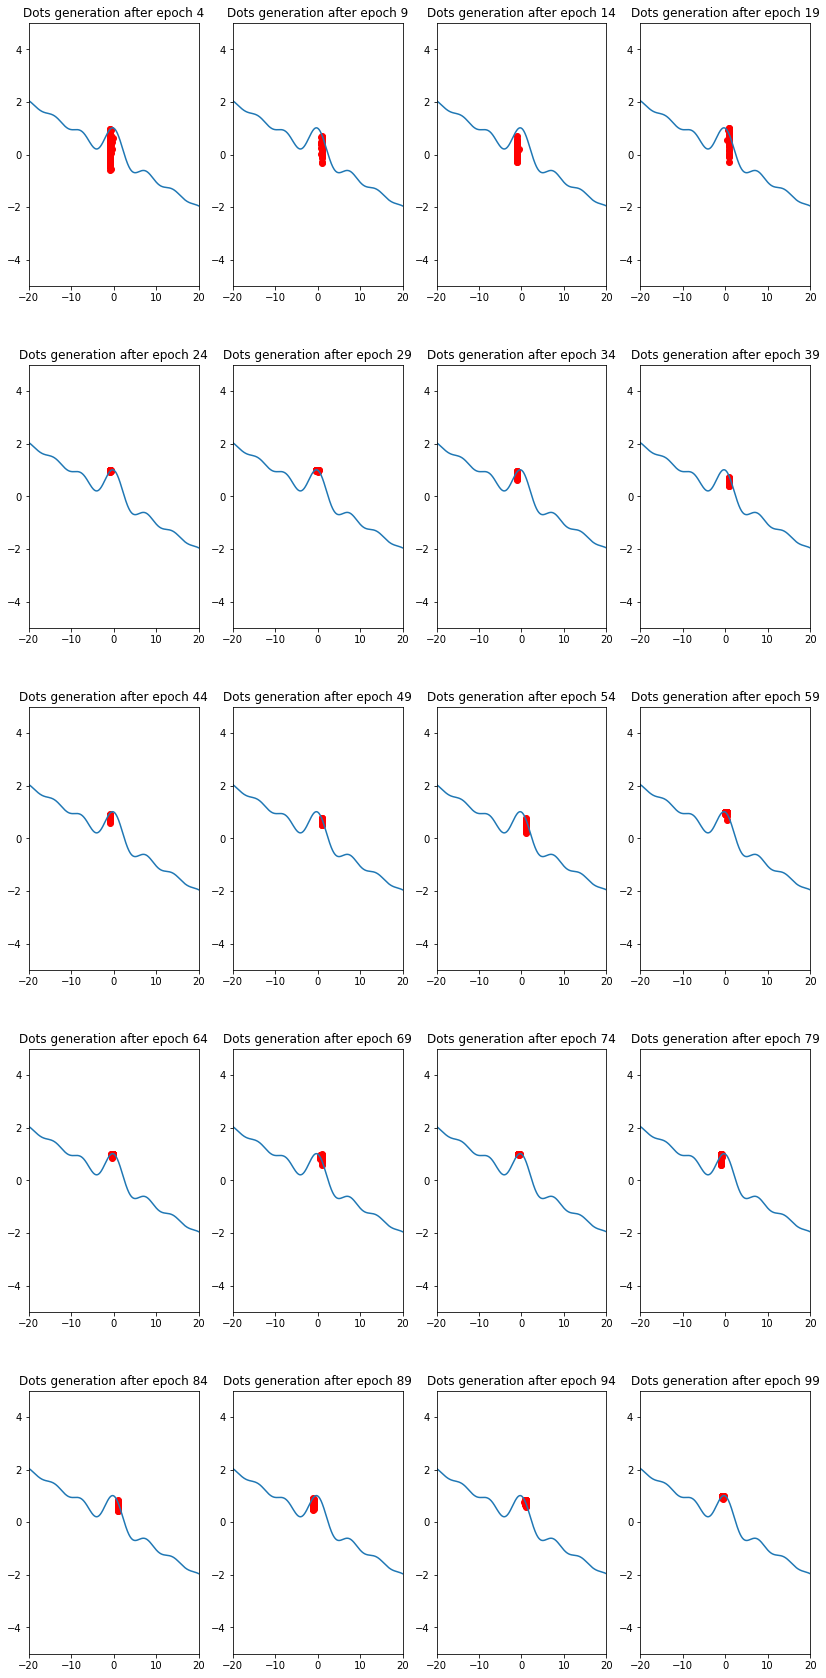

In [142]:
plt.figure(figsize=(14, 30))
for i, dot in enumerate(dots_history):
    if i % 5 == 4:
        plt.subplot(5,4, (i+4)//5)
        plt.plot(x, y)
        plt.scatter(dot[:, 0], dot[:, 1], color='red')
        plt.subplots_adjust(hspace=0.3)
        plt.title(f'Dots generation after epoch {i}')
        xlim = (min(-20, dot[:, 0].min()), max(20, dot[:, 0].max()))
        ylim = (min(-5, dot[:, 1].min()), max(5, dot[:, 1].max()))
        plt.xlim(xlim)
        plt.ylim(ylim)

plt.show()